<a name='introduction'></a>
# Проект "Прогнозирование отмены брони в отеле"

**Введение**

Заказчик - отель. Проблема - в отеле некоторые постояльцы отменяют бронь номеров, что вытекает в расходы компании. Задача - необходимо разработать систему прогнозирования отмены брони номера постояльца по имеющимся признакам. Бюджет разработки системы прогнозирования - 400 000 рублей. Важно, чтобы с внедрением системы прогнозирования (учитывая ее бюджет), отель увеличил свою прибыль.

<br>**План работы**:
- [1. Импорт библиотек и файлов](#import)
- [2. Предобработка и исследовательский анализ данных](#data_preprocessing)
- [3. Формулировка ML-задачи на основе бизнес-задачи](#ml_task)
- [4. Разработка модели ML](#ml_development)
- [5. Описание портера "ненадежного" клиента](#unreliable_client_info)
- [6. Общий вывод](#conclusion)

<a name='open_file'></a>
## 1. Импорт библиотек и файлов

In [1]:
!pip install phik

In [2]:
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

In [3]:
hotel_train = pd.read_csv("hotel_train.csv")
hotel_test = pd.read_csv("hotel_test.csv")

<a name='data_preprocessing'></a>
## 2. Предобработка и исследовательский анализ данных
[Вернуться во Введение](#introduction)

Осуществим первоначально предобработку и исследовательский анализ данных по тренировочной базе данных.

In [4]:
# Посмотрим таблицу на наличие отсутствующих значений
print("hotel_train:")
display(hotel_train.isna().sum())
print("\nhotel_test:")
display(hotel_test.isna().sum())

hotel_train:


id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


hotel_test:


id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

In [5]:
hotel_train['meal']

0        BB       
1        BB       
2        BB       
3        FB       
4        BB       
           ...    
65224    BB       
65225    HB       
65226    BB       
65227    SC       
65228    BB       
Name: meal, Length: 65229, dtype: object

Удалим столбец 'id', поскольку количество уникальных значений совпадает с общим числом объектов и рассмотрим полные дубликаты в каждом из датасетов.

In [6]:
print("Кол-во уникальных значений по 'id':")
print("\tTrain:", len(hotel_train['id'].unique()))
print("\tTest:", len(hotel_test['id'].unique()), "\n")

hotel_train = hotel_train.drop('id', axis=1)
hotel_test = hotel_test.drop('id', axis=1)

Кол-во уникальных значений по 'id':
	Train: 65229
	Test: 32412 



Заменим значения в столбце 'arrival_date_month' на числовое обозначение месяца с помощью datetime

In [7]:
def get_month_num(data):
    for index, row in data.iterrows():
        month_num = dt.datetime.strptime(row['arrival_date_month'].strip(), '%B').month
        data.loc[index, 'arrival_date_month'] = month_num

get_month_num(hotel_train)
get_month_num(hotel_test)

Уберем лишние пробелы после значений качественных признаков, таких как "meal" и "reserved_room_type"

In [8]:
def strip_cols(data):
    data['meal'] = data['meal'].str.strip()
    data['reserved_room_type'] = data['reserved_room_type'].str.strip()

strip_cols(hotel_train)
strip_cols(hotel_test)

display(hotel_train.info())
display(hotel_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65229 non-null  int64  
 1   lead_time                       65229 non-null  float64
 2   arrival_date_year               65229 non-null  int64  
 3   arrival_date_month              65229 non-null  object 
 4   arrival_date_week_number        65229 non-null  int64  
 5   arrival_date_day_of_month       65229 non-null  int64  
 6   stays_in_weekend_nights         65229 non-null  int64  
 7   stays_in_week_nights            65229 non-null  int64  
 8   adults                          65229 non-null  float64
 9   children                        65229 non-null  float64
 10  babies                          65229 non-null  float64
 11  meal                            65229 non-null  object 
 12  country                         

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     32412 non-null  int64  
 1   lead_time                       32412 non-null  float64
 2   arrival_date_year               32412 non-null  int64  
 3   arrival_date_month              32412 non-null  object 
 4   arrival_date_week_number        32412 non-null  int64  
 5   arrival_date_day_of_month       32412 non-null  int64  
 6   stays_in_weekend_nights         32412 non-null  int64  
 7   stays_in_week_nights            32412 non-null  int64  
 8   adults                          32412 non-null  float64
 9   children                        32412 non-null  float64
 10  babies                          32412 non-null  float64
 11  meal                            32412 non-null  object 
 12  country                         

None

Рассмотрим основные показатели количественных переменных по датасетам hotel_train и hotel_test для выявления возможных аномальных значений с помощью функции describe()

In [9]:
display(hotel_train.describe())
display(hotel_test.describe())

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Никаких аномальных значений (количество дней в месяце > 31 или < 0; общее кол-во ночей < 0 и т.д.)  выявлено не было. Перейдем далее к рассмотрению матрицы коэффициентов корреляции phik.

interval columns not set, guessing: ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']


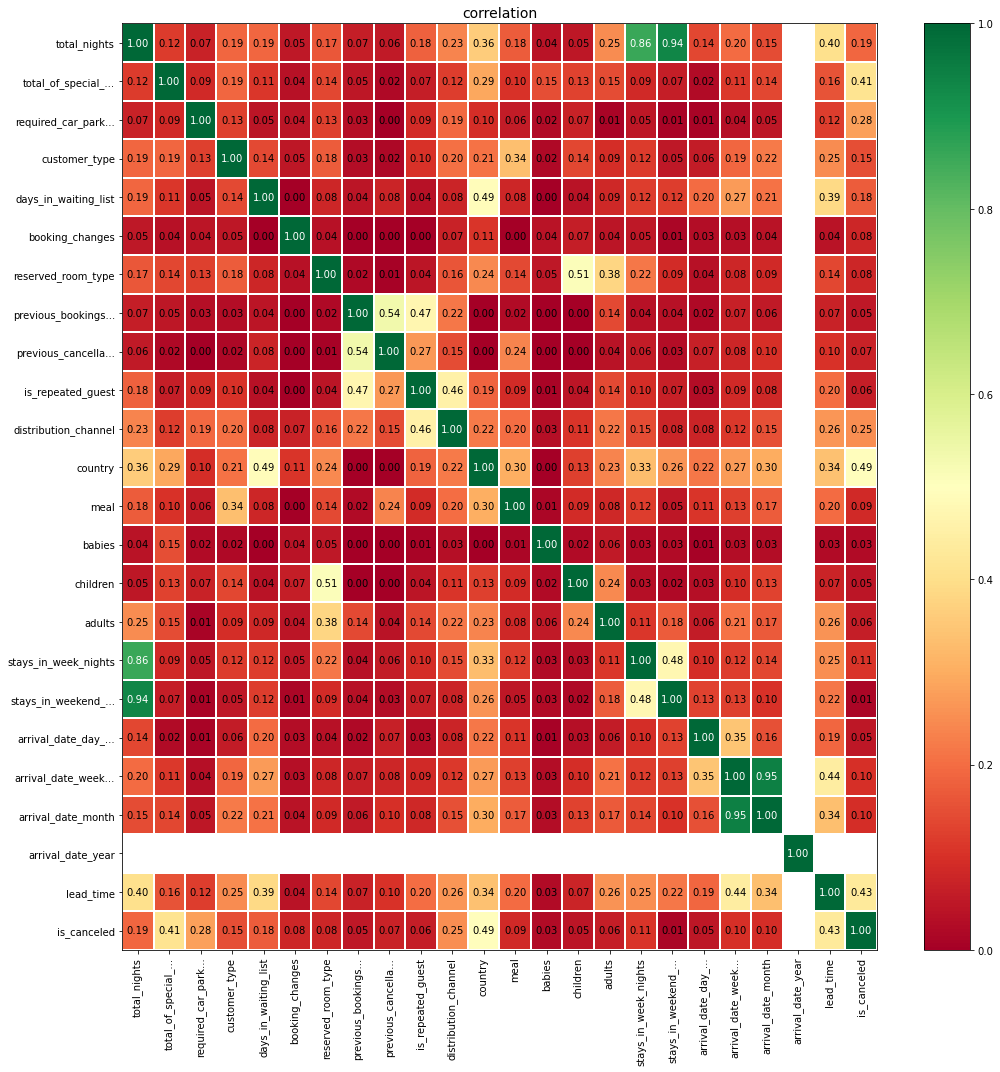

In [10]:
# Отобразим корреляцию phik
phik_overview = hotel_train.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    figsize=(15, 15)
)

**Промежуточный вывод:**
    
Можно заметить небольшие значения корреляции между 'lead_time' (количество дней между датой бронирования и датой прибытия) и 'is_canceled' (собственно отмена заказа), между 'country' (гражданство постояльца) и 'is_canceled', а также между 'total_of_special_requests' (количество специальных отметок) и 'is_canceled'. Каждое значений корреляции рассмотренных параметров выше 0,4, но не превышает 0,5.

In [11]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65229 non-null  int64  
 1   lead_time                       65229 non-null  float64
 2   arrival_date_year               65229 non-null  int64  
 3   arrival_date_month              65229 non-null  object 
 4   arrival_date_week_number        65229 non-null  int64  
 5   arrival_date_day_of_month       65229 non-null  int64  
 6   stays_in_weekend_nights         65229 non-null  int64  
 7   stays_in_week_nights            65229 non-null  int64  
 8   adults                          65229 non-null  float64
 9   children                        65229 non-null  float64
 10  babies                          65229 non-null  float64
 11  meal                            65229 non-null  object 
 12  country                         

Далее посмотрим на доли клиентов по некоторым категориальным параметрам - country (гражданство постояльца), reserved_room_type (категория номера), meal (опция заказа), customer_type (тип заказчика), distribution_channel (канал дистрибуции заказа).

In [12]:
def customers_by_category(category):
    category_df = hotel_train.pivot_table(index=category, values='is_canceled', aggfunc='count').reset_index()
    category_df.columns = [category, 'count']
    
    for index, row in category_df.iterrows():
        percentage = round(row['count'] / category_df['count'].sum() * 100, 1)
        category_df.loc[index, 'percentage'] = percentage

    return category_df.sort_values(by='count', ascending=False)

In [13]:
print("Доля клиентов по некоторым категориальным параметрам:")

display("По гражданству:", customers_by_category('country').head(10))
print("Можно заметить, что преобладают жители Евросоюза. В преимуществе своем - жители португалии,",
      "на которых приходится более 44% всех посетителей.")

display("По категории номера:", customers_by_category('reserved_room_type').head(10))
print("Преимущественно бронируют номера категорий 'A' и 'D'. На эти две категории приходится", 
      "77,4% и 14,4% всех бронирующих потребителей в отеле. В совокупности они дают более 90% всех клиентов.")

display("По опции заказа:", customers_by_category('meal').head(10))
print("Необходимо отметить, что постояльцы предпочитают включенный завтрак, поскольку как правило до 12:00",
      "необходимо выселяться в последний день проживания, с утра, вероятно, хочется больше расслабиться.",
      "Некоторые также предпочитают использовать дополнительные опции заказа обеда.")

display("По типу заказчика:", customers_by_category('customer_type').head(10))
print("Основными заказчика, как впрочем и по всему миру, являются одиночные постояльцы (без групп),",
      "которые приезжают на относительно короткий срок. Их порядка 70% от числа всех постояльцев.")

display("По каналу дистрибуции заказа:", customers_by_category('distribution_channel').head(10))
print("Преимущественное большинство - около 83,5% - предпочитают осуществлять бронь номеров с помощью",
      "турагентов и туроператоров. Лишь 10% осуществляют это напрямую.")

Доля клиентов по некоторым категориальным параметрам:


'По гражданству:'

,country,count,percentage
117,PRT,28831,44.2
48,FRA,5974,9.2
50,GBR,5109,7.8
44,ESP,4900,7.5
37,DEU,3887,6.0
70,ITA,2327,3.6
65,IRL,1445,2.2
12,BEL,1245,1.9
106,NLD,1166,1.8
21,BRA,1088,1.7


Можно заметить, что преобладают жители Евросоюза. В преимуществе своем - жители португалии, на которых приходится более 44% всех посетителей.


'По категории номера:'

,reserved_room_type,count,percentage
0,A,50501,77.4
3,D,9387,14.4
4,E,2448,3.8
5,F,1213,1.9
1,B,860,1.3
6,G,592,0.9
2,C,228,0.3


Преимущественно бронируют номера категорий 'A' и 'D'. На эти две категории приходится 77,4% и 14,4% всех бронирующих потребителей в отеле. В совокупности они дают более 90% всех клиентов.


'По опции заказа:'

,meal,count,percentage
0,BB,51697,79.3
2,HB,7292,11.2
3,SC,5789,8.9
1,FB,451,0.7


Необходимо отметить, что постояльцы предпочитают включенный завтрак, поскольку как правило до 12:00 необходимо выселяться в последний день проживания, с утра, вероятно, хочется больше расслабиться. Некоторые также предпочитают использовать дополнительные опции заказа обеда.


'По типу заказчика:'

,customer_type,count,percentage
2,Transient,45493,69.7
3,Transient-Party,16703,25.6
0,Contract,2746,4.2
1,Group,287,0.4


Основными заказчика, как впрочем и по всему миру, являются одиночные постояльцы (без групп), которые приезжают на относительно короткий срок. Их порядка 70% от числа всех постояльцев.


'По каналу дистрибуции заказа:'

,distribution_channel,count,percentage
3,TA/TO,54454,83.5
1,Direct,6853,10.5
0,Corporate,3823,5.9
2,GDS,99,0.2


Преимущественное большинство - около 83,5% - предпочитают осуществлять бронь номеров с помощью турагентов и туроператоров. Лишь 10% осуществляют это напрямую.


Удалим объекты с аномальными значениями: кол-во детей больше 5, необходимое количество парковочных мест больше 4, кол-во детей больше 5, бронировение номеров детьми без взрослых

In [14]:
def remove_anomalies(data_frame):
    data_frame.drop(data_frame[data_frame['babies'] > 5].index, inplace=True)
    data_frame.drop(data_frame[data_frame['required_car_parking_spaces'] > 4].index, inplace=True)
    data_frame.drop(data_frame[data_frame['children'] > 5].index, inplace=True)
    data_frame.drop(data_frame[data_frame['adults'] == 0].index, inplace=True)

remove_anomalies(hotel_train)
remove_anomalies(hotel_test)

Посмотрим на соотносение общего количества ночей, также суммы ночей по будням и выходным

In [15]:
print("Всего объектов:", hotel_train['adults'].count())
print("Количество значений, когда общее число ночей совпадает с суммой ночей в будние и выходные дни:", 
      hotel_train[hotel_train['total_nights'] == hotel_train['stays_in_week_nights'] + \
                  hotel_train['stays_in_weekend_nights']]['adults'].count())

Всего объектов: 65061
Количество значений, когда общее число ночей совпадает с суммой ночей в будние и выходные дни: 65061


Стоит учесть и тот факт, что некоторые значения могут быть уникальны для одного из датасетов (тренировочного или тестового). Поскольку они характерны только для одного датасета, следовательно, модель не будет использовать информацию о таких значениях параметров в другом датасете. Ввиду этого необходимо удалить некоторые уникальные значения по таким столбцам, как "arrival_date_month" и "country" в каждом из датасетов. В дополнение, при осуществлении в дальнейшем обучения и прогнозирования значения с помощью техники One-Hot Encoding количество столбцов должно совпадать, что и будет обеспечиваться удалением уникальных для каждого из датасетов значений по этим параметрам.

In [16]:
print("Кол-во уникальных стран для каждого из датасетов - ")
print("\tTrain:", len(hotel_train['country'].unique()))
print("\tTest:", len(hotel_test['country'].unique()), '\n')
 
print("Кол-во уникальных значений по месяцу заезда по каждому из датасетов -")
print("\tTrain:", len(hotel_train['arrival_date_month'].unique()))
print("\tTest:", len(hotel_test['arrival_date_month'].unique()))

Кол-во уникальных стран для каждого из датасетов - 
	Train: 155
	Test: 143 

Кол-во уникальных значений по месяцу заезда по каждому из датасетов -
	Train: 12
	Test: 8


In [17]:
obj_num = 0
train_unique_countries = []
 
for country in hotel_train['country'].unique():
    if country not in hotel_test['country'].unique(): 
        train_unique_countries.append(country)
        obj_num += hotel_train[hotel_train['country'] == country].shape[0]
        
print("Кол-во клиентов из стран, которых нет в тестовом датасете:", obj_num)
 
obj_num = 0
test_unique_countries = []
 
for country in hotel_test['country'].unique():
    if country not in hotel_train['country'].unique():
        test_unique_countries.append(country)
        obj_num += hotel_test[hotel_test['country'] == country].shape[0]
        
print("Кол-во клиентов из стран, которых нет в тренировочном датасете:", obj_num)

Кол-во клиентов из стран, которых нет в тестовом датасете: 79
Кол-во клиентов из стран, которых нет в тренировочном датасете: 26


In [18]:
# Удалим информацию о клиентах, которые являются гражданами уникальных для одного из датасетов стран
 
hotel_train = hotel_train[hotel_train['country'].isin(hotel_test['country'].unique())]
hotel_test = hotel_test[hotel_test['country'].isin(hotel_train['country'].unique())]
 
hotel_train = hotel_train[hotel_train['arrival_date_month'].isin(hotel_test['arrival_date_month'].unique())]

In [19]:
hotel_train = hotel_train[hotel_train['country'].isin(hotel_test['country'].unique())]
hotel_test = hotel_test[hotel_test['country'].isin(hotel_train['country'].unique())]

Для того, чтобы в дальнейшем облегчить задачу подсчета финансовых результатов внедрения системы, создадим отдельные дата сеты, которые будут использованы специально для расчеты прибыльности.

In [20]:
hotel_train_clean = hotel_train  # В отдельной переменной оставим неизмененный датасет для портрета "ненадежного"
hotel_test_profit = hotel_test.reset_index(drop=True)  # ... для расчета прибыли

In [21]:
# Удалим столбец 'total_nights', поскольку сумма значений 'stays_in_weekend_nights' и 'stays_in_week_nights'
# дает нам необходимые сведения о длительности проживания

hotel_train = hotel_train.drop(['total_nights'], axis=1)
hotel_test = hotel_test.drop(['total_nights'], axis=1)

Отобразим на графиках соотношение отменивших и неотменивших бронь по признакам в процентном выражении

In [22]:
def create_ratio_plot(col_name, str_name, bar_color):
    # Создадим DataFrame с количеством отменивших / неотменивших бронь по заявленному признаку
    ratio_df = hotel_train.pivot_table(
        index=[col_name, 'is_canceled'], 
        values='country', 
        aggfunc='count'
    ).reset_index()

    # Сохраним соотношения по каждому из уникальных значений заявленного признака
    percentages = []
    for index, row in ratio_df.iterrows():
        if index % 2 == 0:
            try:
                percentage = round(ratio_df.iloc[index + 1]['country'] / row['country'] * 100, 2)
            except IndexError:
                percentage = 0
            percentages.append(percentage)

    # Создадим DataFrame с соотношением
    ratio_df = pd.DataFrame(
        {
            col_name: sorted(hotel_train[col_name].unique()),
            'percentage': [perc for perc in percentages]
        }, 
        index=range(0, len(hotel_train[col_name].unique()))
    )

    # Построим график соотношения отменивших / неотменивших бронь по заявленному признаку
    ratio_df.plot(
        y='percentage',
        x=col_name,
        kind='bar',
        grid=True,
        legend=False,
        figsize=(6, 4),
        color=bar_color
    )

    plt.xlabel(str_name)
    plt.xticks(rotation=0)
    plt.ylabel('Процент отменивших бронь')
    plt.title(f'Соотношение отменивших/неотменивших\nпо "{str_name}", в %.')
    plt.show()

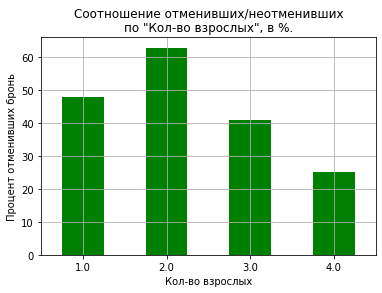

Заметно, что с увеличением количества проживающих взрослых соотношение отменивших отменивших к неотменившим повышается. Необходимо отметить, что выборка объектов с 4-мя взрослыми нерепрезентативна (составляет всего 13 объектов).


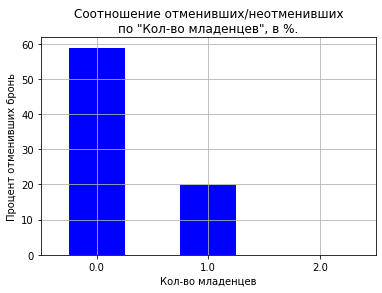

В случае же с количеством младенцем ситуация немного иная (хотя при кол-ве младенцев равном двум выборка также нерепрезентативна - лишь 3 объекта). Тем не менее, при наличии младенца соотношение отменивших к неотменившим снижается.


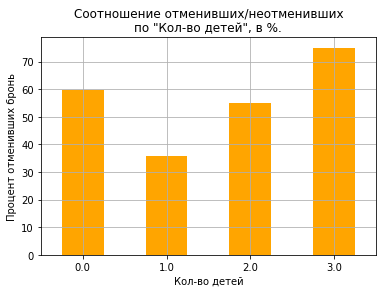

Судя по графику, можно заметить, что при повышении количества детей число отменивших бронь номера также повышается, достигая почти 60%.


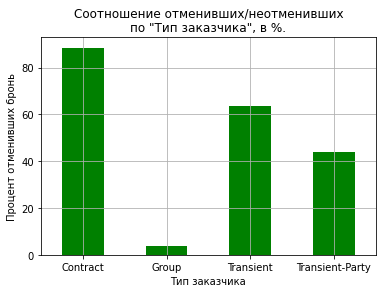

Больше всего осуществляют отмену брони те заказчики, которые бронируют самостоятельно - чуть более 35%. На остальные категории приходится по крайне мере на 10% меньше. А по договору и вовсе - лишь около 8% заказчиков отменяют бронь.


In [23]:
create_ratio_plot('adults', 'Кол-во взрослых', 'green')
print("Заметно, что с увеличением количества проживающих взрослых соотношение отменивших отменивших",
      "к неотменившим повышается. Необходимо отметить, что выборка объектов с 4-мя взрослыми",
      "нерепрезентативна (составляет всего 13 объектов).")

create_ratio_plot('babies', 'Кол-во младенцев', 'blue')
print("В случае же с количеством младенцем ситуация немного иная (хотя при кол-ве младенцев равном двум",
      "выборка также нерепрезентативна - лишь 3 объекта). Тем не менее, при наличии младенца соотношение",
      "отменивших к неотменившим снижается.")

create_ratio_plot('children', 'Кол-во детей', 'orange')
print("Судя по графику, можно заметить, что при повышении количества детей число отменивших бронь номера",
      "также повышается, достигая почти 60%.")

create_ratio_plot('customer_type', 'Тип заказчика', 'green')
print("Больше всего осуществляют отмену брони те заказчики, которые бронируют самостоятельно - чуть более 35%.",
      "На остальные категории приходится по крайне мере на 10% меньше. А по договору и вовсе",
      "- лишь около 8% заказчиков отменяют бронь.")

In [24]:
def create_boxplot(col_name, str_name):
    sns.boxplot(x=hotel_train[col_name])
    plt.title(f"Диаграмма размаха объектов\nпо '{str_name}'")
    plt.grid()
    plt.show()

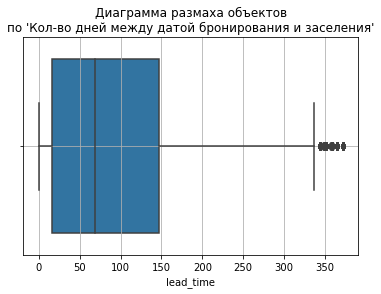

Бронирование осуществляется как правило в период до 100 дней до заселения. Для отдельных постояльцев значение данного показателя может доходить до более года.


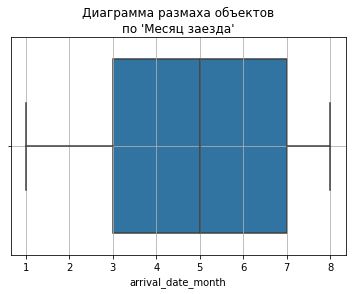

Люди предпочитают скорее размещаться в отеле в период с мая по октября, однако данный показатель охватывает все месяца года.


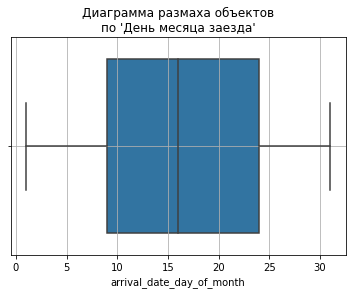

Большинство постояльцев заезжает в отель в середине месяца, около 16-го числа, однако, особого скопления объектов по определенному диапазону значений не наблюдается.


In [25]:
create_boxplot('lead_time', "Кол-во дней между датой бронирования и заселения")
print("Бронирование осуществляется как правило в период до 100 дней до заселения.", 
      "Для отдельных постояльцев значение данного показателя может доходить до более года.")

create_boxplot('arrival_date_month', 'Месяц заезда')
print("Люди предпочитают скорее размещаться в отеле в период с мая по октября,",
      "однако данный показатель охватывает все месяца года.")

create_boxplot('arrival_date_day_of_month', 'День месяца заезда')
print("Большинство постояльцев заезжает в отель в середине месяца, около 16-го числа, однако,",
      "особого скопления объектов по определенному диапазону значений не наблюдается.")

<a name='ml_task'></a>
### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

По условию задачи нам необходимо разработать систему прогнозирования оплаты / отмены брони для отеля. Отель получает убытки в случае, если бронь отменяется. Система прогнозирования отмены брони номера позволит предугадать, отменит ли постоялец свою бронь, что поможет сэкономить отелю (сократит издержки) и, следовательно, повысить прибыль организации.

1. При внедрении данной системы отель может понести убытки, если ложно предскажет, что пользователь в конечном счете не отменит бронь, но отмена все-таки произойдет (ложноотрицательные предсказания). Ввиду этого необходимо использовать метрику 'recall', которая как раз будет высчитывать долю правильно положительных ответов модели машинного обучения.
2. В дополнение можно рассмотреть и значения F1-меры, поскольку она сочетает в себе оценку метрик recall и precision, и продемонстрирует способность модели различать необходимый класс от иных, а также правильно определять его.
3. Также необходимо использовать и AUC-ROC (площадь под кривой ROC), поскольку она демонстрирует, насколько модель лучше абсолютно случайно модели, значение метрики которой составляет 0,5. 
4. Рассмотрим также случай, что половина постояльцев, которым будет предложено внесения депозита, откажется от брони, ввиду нежелания осуществления предварительной оплаты. В данном случае будет наглядно продемонстрировано, насколько эффективно будет внедрение системы, даже если часть постояльцев откажется от бронирования номера.

<a name='ml_development'></a>
### Шаг 4. Разработка модели ML

Применим две техники кодирования - прямую и порядковую (One-Hot Encoding & Ordinal Encoding) для различных моделей.

In [26]:
# Создание отдельного DataFrame, а также переменных с использованием One-Hot Encoding (прямое кодирование)

pd.options.mode.chained_assignment = None

df_ohe_train = pd.get_dummies(hotel_train, drop_first=True)

X_train_ohe = df_ohe_train.drop('is_canceled', axis=1)
y_train_ohe = df_ohe_train['is_canceled']
 
scaler = StandardScaler()
scaler.fit(X_train_ohe)

X_train_ohe = scaler.transform(X_train_ohe)

# То же самое для тестовой выборки

df_ohe_test = pd.get_dummies(hotel_test, drop_first=True)

X_test_ohe = df_ohe_test.drop('is_canceled', axis=1)
y_test_ohe = df_ohe_test['is_canceled']

scaler = StandardScaler()
scaler.fit(X_test_ohe)

X_test_ohe = scaler.transform(X_test_ohe)

In [27]:
# Создание отдельного DataFrame и переменных с использованием Ordinal Encoding (порядковое кодирование)

encoder = OrdinalEncoder()
encoder.fit(hotel_train)

df_ord_train = pd.DataFrame(
    encoder.fit_transform(hotel_train),
    columns=hotel_train.columns
)

X_train_ord = df_ord_train.drop('is_canceled', axis=1)
y_train_ord = df_ord_train['is_canceled']

# То же самое для тестовой выборки

encoder = OrdinalEncoder()
encoder.fit(hotel_test)

df_ord_test = pd.DataFrame(
    encoder.fit_transform(hotel_test),
    columns=hotel_test.columns
)

X_test_ord = df_ord_test.drop('is_canceled', axis=1)
y_test_ord = df_ord_test['is_canceled']

Определим лучшие значения гиперпараметров для каждой из рассмтариваемых моделей: Дерева решений (DecisionTreeClassifier), Случайного леса (RandomForestClassifier) и Логистической регрессии (LogisticRegression) с помощью GridSearchCV.

In [28]:
# Рассматриваемые метрики
scoring = ['recall', 'f1', 'roc_auc']

In [29]:
model = DecisionTreeClassifier(random_state=42)

param_grid = {'max_depth': range(2, 21, 2), 'criterion': ['gini', 'entropy']}

grid = GridSearchCV(model, param_grid, scoring=scoring, refit='recall')
grid.fit(X_train_ord, y_train_ord)

metrics_columns = [f'mean_test_{x}' for x in scoring]
final_metrics = pd.DataFrame(grid.cv_results_)[metrics_columns].iloc[grid.best_index_]

print(grid.best_estimator_)
display(final_metrics)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)


mean_test_recall     0.479352
mean_test_f1         0.432736
mean_test_roc_auc    0.655544
Name: 12, dtype: float64

In [30]:
%%time

# P. S. Время на инициализацию данного блока кода - 32,5 минут

'''
model = RandomForestClassifier(random_state=42)

param_grid = {'max_depth': range(2, 21, 2), 'n_estimators': range(50, 351, 50), 'criterion': ['gini', 'entropy']}

grid = GridSearchCV(model, param_grid, scoring=scoring, refit='recall')
grid.fit(X_train_ord, y_train_ord)

metrics_columns = [f'mean_test_{x}' for x in scoring]
final_metrics = pd.DataFrame(grid.cv_results_)[metrics_columns].iloc[grid.best_index_]

print(grid.best_estimator_)
display(final_metrics)
'''

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.25 µs


"\nmodel = RandomForestClassifier(random_state=42)\n\nparam_grid = {'max_depth': range(2, 21, 2), 'n_estimators': range(50, 351, 50), 'criterion': ['gini', 'entropy']}\n\ngrid = GridSearchCV(model, param_grid, scoring=scoring, refit='recall')\ngrid.fit(X_train_ord, y_train_ord)\n\nmetrics_columns = [f'mean_test_{x}' for x in scoring]\nfinal_metrics = pd.DataFrame(grid.cv_results_)[metrics_columns].iloc[grid.best_index_]\n\nprint(grid.best_estimator_)\ndisplay(final_metrics)\n"

In [31]:
%%time

# P. S. Время на исполнение данного блока кода - 14,5 минут

'''
model = LogisticRegression(solver='liblinear', random_state=42)

param_grid = {'max_iter': range(100, 501, 100), 'penalty': ['l2', 'l1']}

grid = GridSearchCV(model, param_grid, scoring=scoring, refit='recall')
grid.fit(X_train_ohe, y_train_ohe)

metrics_columns = [f'mean_test_{x}' for x in scoring]
final_metrics = pd.DataFrame(grid.cv_results_)[metrics_columns].iloc[grid.best_index_]

print(grid.best_estimator_)
display(final_metrics)
'''

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


"\nmodel = LogisticRegression(solver='liblinear', random_state=42)\n\nparam_grid = {'max_iter': range(100, 501, 100), 'penalty': ['l2', 'l1']}\n\ngrid = GridSearchCV(model, param_grid, scoring=scoring, refit='recall')\ngrid.fit(X_train_ohe, y_train_ohe)\n\nmetrics_columns = [f'mean_test_{x}' for x in scoring]\nfinal_metrics = pd.DataFrame(grid.cv_results_)[metrics_columns].iloc[grid.best_index_]\n\nprint(grid.best_estimator_)\ndisplay(final_metrics)\n"

Сохраненные отдельно значения метрик по каждой из моделей (плюс наилучшее сочетание их гиперпараметров):

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)
- mean_test_recall     0.479352
- mean_test_f1         0.432736
- mean_test_roc_auc    0.655544
    - Среднее значение: 0.522544

RandomForestClassifier(max_depth=8, n_estimators=50, random_state=42)
- mean_test_recall     0.459280
- mean_test_f1         0.492341
- mean_test_roc_auc    0.655621
    - Среднее значение: 0.535747

LogisticRegression(random_state=42, solver='liblinear')
- mean_test_recall     0.488424
- mean_test_f1         0.490556
- mean_test_roc_auc    0.677027
    - Среднее значение: 0.552002

Осуществим финальное тестирование модели логистической регрессии, поскольку и среднее значение метрик и значение основной метрики - recall - наивысшее среди рассматриваемых моделей.

In [32]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train_ohe, y_train_ohe)

y_pred = pd.Series(model.predict(X_test_ohe))

score_recall = recall_score(y_test_ohe, y_pred)
score_f1 = f1_score(y_test_ord, y_pred)
score_roc_auc = roc_auc_score(y_test_ohe, y_pred)

print("Recall:", round(score_recall, 3))
print("F1-мера:", round(score_f1, 3))
print("AUC-ROC:", round(score_roc_auc, 3))

Recall: 0.576
F1-мера: 0.646
AUC-ROC: 0.722


**Промежуточный вывод:**

Наилучшие значения выбранных метрик демонстрирует именно логистическая регрессия, что подтверждается и на тестовой выборке. Ввиду этого в дальнейшем будет использована именно модель логистической регрессии для прогнозирования возможной прибыли внедрения данной системы в хозяйственную деятельность отеля.

Переменные X_train, y_train, X_test, y_test заменим на такие же, но с применением One-Hot Encoding, поскольку в дальнейшем будем работать только с логистической регрессией.

In [33]:
X_train, y_train = X_train_ohe, y_train_ohe
X_test, y_test = X_test_ohe, y_test_ohe

Далее рассчитаем вероятную прибыль на тестовой датасете с помощью обученной на тренировочном датасете модели логистической регрессии

In [34]:
# Введем глобальные переменные

BUDGET = 400_000
AUTUMN_SPRING_COEF = 1.2
SUMMER_COEF = 1.4
DEPOSIT = 0.8
ROOMS_TYPE = {
    'A': {'price': 1000, 'service': 400},
    'B': {'price': 800, 'service': 350},
    'C': {'price': 600, 'service': 350},
    'D': {'price': 550, 'service': 150},
    'E': {'price': 500, 'service': 150},
    'F': {'price': 450, 'service': 150},
    'G': {'price': 350, 'service': 150}
}

Подсчитаем вероятную выручку, затраты и собственно прибыль, которую отель может получить, в двух случаях:
- При введении системы прогнозирования отмены брони;
- Без введения системы прогнозирования отмены брони (как есть).

Создадим отдельную фукнцию для расчета прибыли и применим ее для расчета прибыли (убытка) для каждого из постояльцев, закрепив значение выручки с отдельно взятого клиента в столбце "profit"

In [35]:
def profit(row, str_type):
    # Учет затрат и выручки с каждого клиента
    costs_for_client = 0
    user_payment = 0

    # Отдельные переменные для каждого из необходимых столбцов 
    index = row.name
    month = row['arrival_date_month']
    room_type = row['reserved_room_type']
    total_nights = row['total_nights']
    price = ROOMS_TYPE[room_type]['price']
    service = ROOMS_TYPE[room_type]['service']

    # Учет сезонных коэффициентов в ценовой политике
    if 3 <= month <= 5 or 9 <= month <= 11:
        price *= AUTUMN_SPRING_COEF
    elif 6 <= month <= 8:
        price *= SUMMER_COEF
    
    if str_type == 'ml':
        # Если система предсказывает отмену брони
        if y_pred.iloc[index] == 1:
            # Представим, что лишь половина согласиться внести депозит (остальные откажутся от брони вовсе)
            if np.random.randint(2) == 1:
                # Внесение депозита и затрат за первую ночь и обслуживание
                user_payment += (price + service) * DEPOSIT
                costs_for_client += price + service

                # Если бронь не отменена - начисление полной стоимости и обслуживания
                if y_test.iloc[index] == 0:
                    user_payment += (price + service) * (1 - DEPOSIT) + (total_nights - 1) * price

                    for i in range(2, total_nights, 2):
                        costs_for_client += service
        # Если система предсказывает покупку, и она осуществляется
        elif y_pred.iloc[index] == 0 and y_test.iloc[index] == 0:
            # Начисление полной стоимости и обслуживания за все дни проживаиня
            user_payment += total_nights * price

            for i in range(0, total_nights, 2):
                costs_for_client += service
        # Если система предсказывает покупку, но осуществлена отмена брони - начисление издержек
        elif y_pred.iloc[index] == 0  and y_test.iloc[index] == 1:
            costs_for_client += price + service
        
    elif str_type == 'no_ml': # Расчет прибыли без внедрения системы прогнозирования
        # Если бронь осуществлена - начисление выручки и затрат
        if y_test.iloc[index] == 0:
            user_payment += total_nights * price
            
            for i in range(0, total_nights, 2):
                costs_for_client += service
        # Если бронь отменена - начисление затрат
        elif y_test.iloc[index] == 1:
            costs_for_client += price + service

    revenue_from_client = user_payment - costs_for_client
    
    return revenue_from_client

In [36]:
# Оставим лишь необходимые сведения для определения стоимости проживания и затрат
hotel_test_profit = hotel_test_profit[['arrival_date_month', 'total_nights', 'reserved_room_type', 'is_canceled']]

# Сохранение предсказанных моделью результатов
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test))

In [37]:
hotel_test_profit['profit_ml'] = hotel_test_profit.apply(lambda x: profit(x, 'ml'), axis=1)
hotel_test_profit['profit_no_ml'] = hotel_test_profit.apply(lambda x: profit(x, 'no_ml'), axis=1)

print("Прибыль - ")
print("\tПри использовании системы прогнозирования:", "{:,}".format(hotel_test_profit['profit_ml'].sum() - BUDGET))
print("\tБез использования системы прогнозирования:", "{:,}".format(hotel_test_profit['profit_no_ml'].sum()))

Прибыль - 
	При использовании системы прогнозирования: 39,576,638.0
	Без использования системы прогнозирования: 35,173,060.0


Рассмотрим подробнее на диаграмме разницу между финансовыми показателями при внедрении системы прогнозирования бронирования и без ее введения
<a name='financial_results'></a>

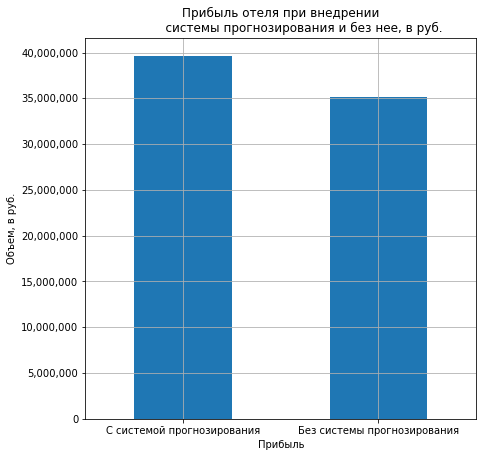

In [38]:
# Отобразим на графике финансовые результаты при внедрении системы прогнозирования отмены брони и без нее
financial_results = pd.DataFrame(
    {
        "Название": ["С системой прогнозирования", "Без системы прогнозирования"],
        "Прибыль": [hotel_test_profit['profit_ml'].sum() - BUDGET, hotel_test_profit['profit_no_ml'].sum()]
    }
)

ax = financial_results.plot(
    x='Название',
    y='Прибыль',
    kind='bar',
    grid=True,
    figsize=(7, 7),
    xlabel='Прибыль',
    ylabel="Объем, в руб.",
    title='Прибыль отеля при внедрении\n \
           системы прогнозирования и без нее, в руб.'
)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.get_legend().remove()
plt.xticks(rotation=0)
plt.show()

**Промежуточный вывод:**

Можно заметить, что введение системы прогнозирования отмены бронирования номера позволит не только сохранить имеющуюся прибыль у отеля, но и повысить ее, поскольку за счет введения депозита в размере 80% от стоимости номера за одни сутки и затрат на разовую уборку. 

При внедрении системы прогнозирования общая прибыль, учитывая и бюджет на внедрение в 400 000 рублей, может в конечном счете достичь около 40 млн рублей - против 35 млн рублей без ее введения (также учитывается тот факт, что примерно половина клиентов откажется от осуществления брония при запросе внесения ими депозита, если система посчитает, что они в конечном итоге отменят свою бронь).

Таким образом можно сделать вывод о целесобразности введения данной системы при осуществлении бронировании клиентами номеров в отеле для снижения риска убытков от простоя номера или закупа не использованных продуктов.

<a name='unreliable_client_info'></a>
### Шаг 5. Опишите портрет «ненадёжного» клиента

Составит портрет "ненадежного" клиента на основании матрицы корреляции phik, которая была ранее  создана в разделе № 2 "Предобработка и исследовательский анализ данных".

Поскольку, основными параметрами, которые в наибольшей степени влияют на целевой признак - отменит ли потенциальный постоялец бронь номера - являются 'lead_time' (количество дней между датой бронирования и датой прибытия), 'country' (гражданство постояльца) и total_of_special_requests (количество специальных отметок), рассмотрим преимущественно их.

In [39]:
# Топ-5 стран, граждане которых больше всего отменяют бронирование номера

hotel_train_clean[hotel_train_clean['is_canceled'] == 1]['country'].value_counts().head()

PRT    9086
ESP     632
FRA     504
ITA     500
GBR     468
Name: country, dtype: int64

Примечательно, что наибольшее количество людей, отменивших бронь комнаты, являются гражданами Португалии. На втором же месте - граждане соседней страны - испанцы. Однако, важно отметить, что первое место опережает ближайших "преследователей" почти в 16 раз! 

In [40]:
# Количество потенциальных клиентов, отменивших бронь, по времени между датами бронирования и прибытия

lead_time_df = hotel_train_clean[hotel_train_clean['is_canceled'] == 1].pivot_table(
    index='lead_time', values='adults', aggfunc='count'
).reset_index()
lead_time_df.columns = ['lead_time', 'clients_number']

lead_time_wo_df = hotel_train_clean[hotel_train_clean['is_canceled'] == 0].pivot_table(
    index='lead_time', values='adults', aggfunc='count'
).reset_index()
lead_time_wo_df.columns = ['lead_time', 'clients_number']

print('С отменой бронирования:')
display(lead_time_df.sort_values(by='clients_number', ascending=False).head(10))
print("Медианное время между прибытием и бронированием:", lead_time_df['lead_time'].median(), "\n\n")

print('Без отмены бронирования:')
display(lead_time_wo_df.sort_values(by='clients_number', ascending=False).head(10))
print("Медианное время между прибытием и бронированием:", lead_time_wo_df['lead_time'].median())

С отменой бронирования:


,lead_time,clients_number
68,68.0,192
1,1.0,160
0,0.0,145
71,71.0,133
113,113.0,131
188,188.0,130
39,39.0,125
56,56.0,125
158,158.0,116
99,99.0,105


Медианное время между прибытием и бронированием: 163.5 


Без отмены бронирования:


,lead_time,clients_number
0,0.0,1845
1,1.0,1048
2,2.0,624
3,3.0,537
4,4.0,519
5,5.0,442
6,6.0,367
7,7.0,309
9,9.0,259
12,12.0,255


Медианное время между прибытием и бронированием: 157.5


Важно отметить, что время между бронированием и прибытием также играет важную роль. И хотя медианное время между теми, кто отменил бронирование номера и те, кто все же этого не сделал сильно не отличается - 181 и 179 соответственно, тем не менее, можно заметить, что волатильность значений в первом случае намного больше. Можно сделать вывод, что человек с большей вероятностью отменит, если медианное время между прибытием и бронированием больше.

In [41]:
total_requests_cancel_df = hotel_train_clean[hotel_train_clean['is_canceled'] == 1].pivot_table(
    index='total_of_special_requests', values='adults', aggfunc='count'
).reset_index()
total_requests_cancel_df.columns = ['total_of_special_requests', 'clients_number']

total_requests_df = hotel_train_clean[hotel_train_clean['is_canceled'] == 0].pivot_table(
    index='total_of_special_requests', values='adults', aggfunc='count'
).reset_index()
total_requests_df.columns = ['total_of_special_requests', 'clients_number']

display("Количество пометок по клиентам, отменивших бронь:", 
        total_requests_cancel_df.sort_values(by='clients_number', ascending=False))
display("Количество пометок по клиентам, не отменивших бронь:", 
        total_requests_df.sort_values(by='clients_number', ascending=False))

'Количество пометок по клиентам, отменивших бронь:'

,total_of_special_requests,clients_number
0,0,11082
1,1,1579
2,2,479
3,3,65
4,4,1


'Количество пометок по клиентам, не отменивших бронь:'

,total_of_special_requests,clients_number
0,0,11296
1,1,8334
2,2,2552
3,3,351
4,4,34
5,5,1


Примечательно, что количество отметок у потенциальных постояльцев преимущественно равняется 0 (как и в случае с теми, кто не отменил бронь), однако, отношение к другому количеству специальных отметок (до 5 включительно) разное в двух случаях. Ввиду этого можно сделать вывод о том, что человек, не отметивший никаких специальных отметок с большей вероятностью отменить бронь, чем тот, кто указал какие-то из них.

**Вывод:**

"Ненадежного" клиента можно характеризовтаь следующий образом:
- Является уроженцев Португалии (с большей вероятностью) или Испании
- Довольно заранее осуществляет бронь комнаты отеля
- Не отмечает никаких специальных пометок

Остальные параметры также можно рассмотреть, однако, в соответствии с матрицей корреляции phik они не играют такую же значимую роль, как рассмотренные ранее параметры.

<a name='conclusion'></a>
### Шаг 6. Напишите общий вывод

В рамках данного проекта была взята база данных о клиентах отеля с различными признаками о них, а также целевым показателем - отменили ли они бронь. Поскольку отель получает убытки ввиду того, что потенциальный постоялец отменяет бронь (как стоимость одного дня проживания в номере, а также разовое обслуживание), то необходимо разработать такую систему, которая бы прогнозировала, будет ли клиентом отменена бронь. В случае, если модель определяет потребителя как "ненадежного", ему необходимо внести депозит в 80% от стоимости одного дня проживания и разового обслуживания.

Первоначально была осуществлена предобработка: не было выявлено никаких аномальных значений, была осуществлена корректировка значений по категориальным столбцам с помощью функции strip(). С помощью исследовательского анализа данных было определно, что наибольшую роль при определении значения целевого признака играют такие параметры, как "гражданство постояльца", "период времени между бронированием и прибытием" и "количество специальных отметок". 

Были определены следующие важные метрики для данной бизнес-задачи: recall, F1-мера и AUC-ROC. 
Наилучшей моделью получилась логистическая регрессия с таким гиперпараметром, как solver = 'liblinear', со следующими значениями данных показателей на тестовой выборке: recall - 0.488, F1-мера - 0.491, AUC-ROC - 0.677. На тестовой же выборке данные показатели логистической регрессии составили: recall - 0.576, F1-мера - 0.646, AUC-ROC - 0.722.

Окончательным шагом проекта был расчет прибыльности внедрения системы.

Прибыль (значения могут незначительно разниться, т. к. используется случайность):
- При внедрении системы прогнозирования - 39 739 710 руб;
- Без введения системы прогнозирования - 35 173 060.

Разница в прибыли при внедрении системы прогнозирования отмены брони превышает изначальную на примерно 5 млн рублей, а затраты - лишь на 400 000 (бюджет внедрения системы прогнозирования бронирования). Увеличение прибыли возможно именно за счет увеличения выручки, что осуществляется при помощи учета депозитов "ненадежных" клиентов.

[Перейти к диаграмме разницы в финансовых результатах в двух случаях](#financial_results)

"Ненадежный" клиент преимущественно отличается следующими характеристиками:
- Является уроженцев Португалии (с большей вероятностью) или Испании
- Довольно заранее осуществляет бронь комнаты отеля
- Не отмечает никаких специальных пометок

**Рекомендации:**

Рекомендуется внедрить системы прогнозирования отмены брони, в основе которой лежит модель логистической регрессии с применением прямого способа кодирования (One-Hot Encoding). Повышение издержек на 400 000 нивелируется значительным повышением прибыли, что является важнейшим финансовым показателем для любой организации.

[Вернуться к введению](#introduction)